In [2]:
!pip install pytesseract

In [5]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.5 MB/s eta 0:00:00


In [6]:
import os
import cv2
import pandas as pd
import pytesseract
from ultralytics import YOLO
from matplotlib import pyplot as plt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [11]:
##load model to google colab and copy paste path to use them


0: 384x640 1 nohelmet, 331.1ms
Speed: 14.7ms preprocess, 331.1ms inference, 39.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 0, 120.8ms
Speed: 3.3ms preprocess, 120.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


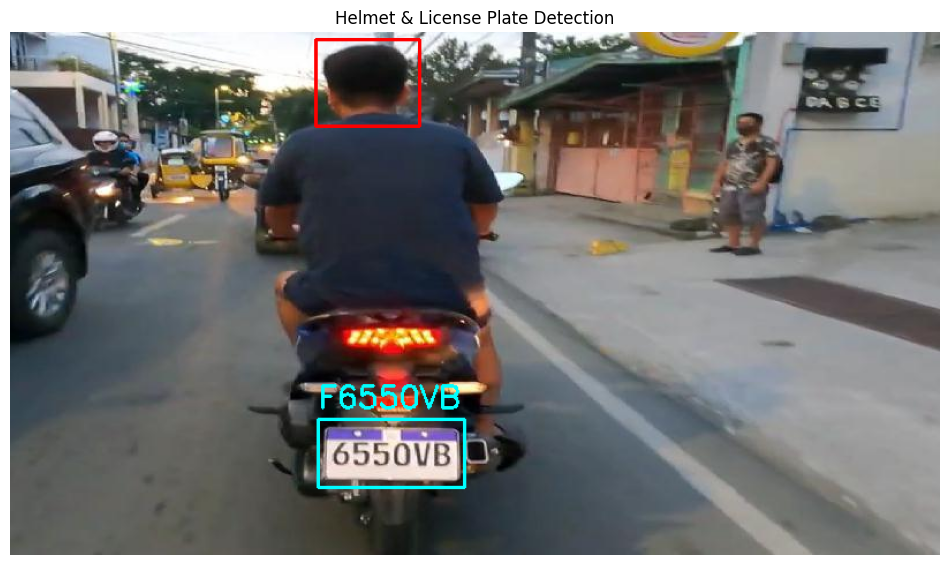

✅ Helmet Status Detected: ['nohelmet']
✅ Plate Numbers Detected: ['F6550VB']


In [10]:
from ultralytics import YOLO
import cv2
import pytesseract
import numpy as np
import gradio as gr

# ---------------- USER CONFIG ----------------
HELMET_MODEL_PATH = "/content/helmet_best.pt"
PLATE_MODEL_PATH = "/content/best.pt"

# Load models
helmet_model = YOLO(HELMET_MODEL_PATH)
plate_model = YOLO(PLATE_MODEL_PATH)

# ---------------- PROCESS FUNCTION ----------------
def process_frame(frame):
    img = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    img_out = img.copy()

    helmet_statuses = []
    plate_texts = []

    # ---- Helmet Detection ----
    helmet_results = helmet_model.predict(img, verbose=False)
    for r in helmet_results:
        for box in r.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = float(box.conf[0])
            cls = int(box.cls[0])
            label = helmet_model.names[cls]

            helmet_statuses.append(label)

            color = (0, 255, 0) if label.lower() == "helmet" else (0, 0, 255)
            cv2.rectangle(img_out, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img_out, f"{label} {conf:.2f}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

    # ---- License Plate Detection ----
    plate_results = plate_model.predict(img, verbose=False)
    for r in plate_results:
        for box in r.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            plate_crop = img[y1:y2, x1:x2]
            if plate_crop.size == 0:
                continue

            gray = cv2.cvtColor(plate_crop, cv2.COLOR_BGR2GRAY)
            plate_text = pytesseract.image_to_string(
                gray,
                config='--psm 8 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
            ).strip()

            if plate_text:
                plate_texts.append(plate_text)

            cv2.rectangle(img_out, (x1, y1), (x2, y2), (255, 255, 0), 2)
            cv2.putText(img_out, plate_text, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 0), 2)

    return cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB), f"Helmet: {helmet_statuses}\nPlates: {plate_texts}"

# ---------------- GRADIO INTERFACE ----------------
with gr.Blocks() as demo:
    gr.Markdown("🚦 Usagi AI (with OCR)")

    with gr.Tab("📷 Webcam"):
        webcam_input = gr.Image()
        webcam_output_img = gr.Image()
        webcam_output_text = gr.Textbox()
        webcam_input.stream(process_frame, [webcam_input], [webcam_output_img, webcam_output_text])

    with gr.Tab("🖼️ Image Upload"):
        img_input = gr.Image(type="numpy")
        img_output = gr.Image()
        img_text = gr.Textbox()
        img_btn = gr.Button("Process Image")
        img_btn.click(process_frame, inputs=[img_input], outputs=[img_output, img_text])

    with gr.Tab("🎥 Video Upload"):
        video_input = gr.Video()
        video_output = gr.Video()
        video_text = gr.Textbox()

        def process_video(video):
            cap = cv2.VideoCapture(video)
            out_frames = []
            texts = []

            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                processed_frame, txt = process_frame(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                out_frames.append(cv2.cvtColor(processed_frame, cv2.COLOR_RGB2BGR))
                texts.append(txt)

            cap.release()

            # Save processed video
            h, w, _ = out_frames[0].shape
            out_path = "processed_video.mp4"
            fourcc = cv2.VideoWriter_fourcc(*"mp4v")
            out = cv2.VideoWriter(out_path, fourcc, 20, (w, h))
            for f in out_frames:
                out.write(f)
            out.release()

            return out_path, "\n".join(texts)

        video_btn = gr.Button("Process Video")
        video_btn.click(process_video, inputs=[video_input], outputs=[video_output, video_text])

demo.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://3fc6a3bb5b5862db3b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://3fc6a3bb5b5862db3b.gradio.live
